In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Get the current notebook's directory
notebook_dir = Path().absolute()

# Set the working directory to the notebook's directory
os.chdir(notebook_dir)

from constants import Cryptos, CCMIX
from local_projections import LocalProjectionsModel
from statistical_tests import TTest,GRANKTTest,GSignTest

In [2]:
CCMIX.load_data()
stat_ar_params = []
ar_params = []
for crypto in Cryptos:
    crypto.value.load_data()
    crypto.value.add_market_returns(CCMIX.data)
    stat = crypto.value.test_stationarity()
    print("Is stationary = ",stat)
    rlt = crypto.value.run_ar_model(p=1,difference=True)
    print("with difference : ",rlt.params)
    rlt = crypto.value.run_ar_model(p=1,difference=False)
    print("without difference : ",rlt.params)
    ar_params.append(rlt.params[1])
    if stat :
        stat_ar_params.append(rlt.params[1])

Data for CCMIX loaded successfully.
Data for Bitcoin Gold loaded successfully.
Market returns added successfully to Bitcoin Gold data.
Is stationary =  True
with difference :  [-0.30484297 -0.1142261 ]
without difference :  [0.7207914  0.97440669]
Data for Einsteinium loaded successfully.
Market returns added successfully to Einsteinium data.
Is stationary =  True
with difference :  [-0.00093258  0.03717103]
without difference :  [0.00522887 0.94896261]
Data for Electroneum loaded successfully.
Market returns added successfully to Electroneum data.
Is stationary =  True
with difference :  [-4.42846179e-05  3.98948342e-02]
without difference :  [1.71255214e-04 9.84590966e-01]
Data for Ethereum Classic loaded successfully.
Market returns added successfully to Ethereum Classic data.
Is stationary =  False
with difference :  [-0.00665759  0.02178009]
without difference :  [0.14494776 0.99162697]
Data for Expanse loaded successfully.
Market returns added successfully to Expanse data.
Is sta

In [3]:
print("mean AR coff for stationary series = ",np.mean(stat_ar_params))
print("mean AR coff for all series = ",np.mean(ar_params))

mean AR coff for stationary series =  0.9765871290851774
mean AR coff for all series =  0.9801937402545807


In [4]:
def testing_abnormal_returns(abnormal_returns):
    # Generalized Rank Test
    grank_test = GRANKTTest(abnormal_returns)
    assumptions_grank = grank_test.verify_assumptions()
    assumptions_grank = pd.DataFrame(assumptions_grank)
    assumptions_grank['name'] = grank_test.name
    grank_stat = grank_test.calculate_test()
    assumptions_grank['value'] = grank_stat


    # Generalized Sign Test
    gsign_test = GSignTest(abnormal_returns)
    assumptions_gsign = gsign_test.verify_assumptions()
    assumptions_gsign = pd.DataFrame(assumptions_gsign)
    assumptions_gsign['name'] = grank_test.name
    gsign_stat = gsign_test.calculate_test()
    assumptions_gsign['value'] = gsign_stat

    return pd.concat([assumptions_grank,assumptions_gsign])

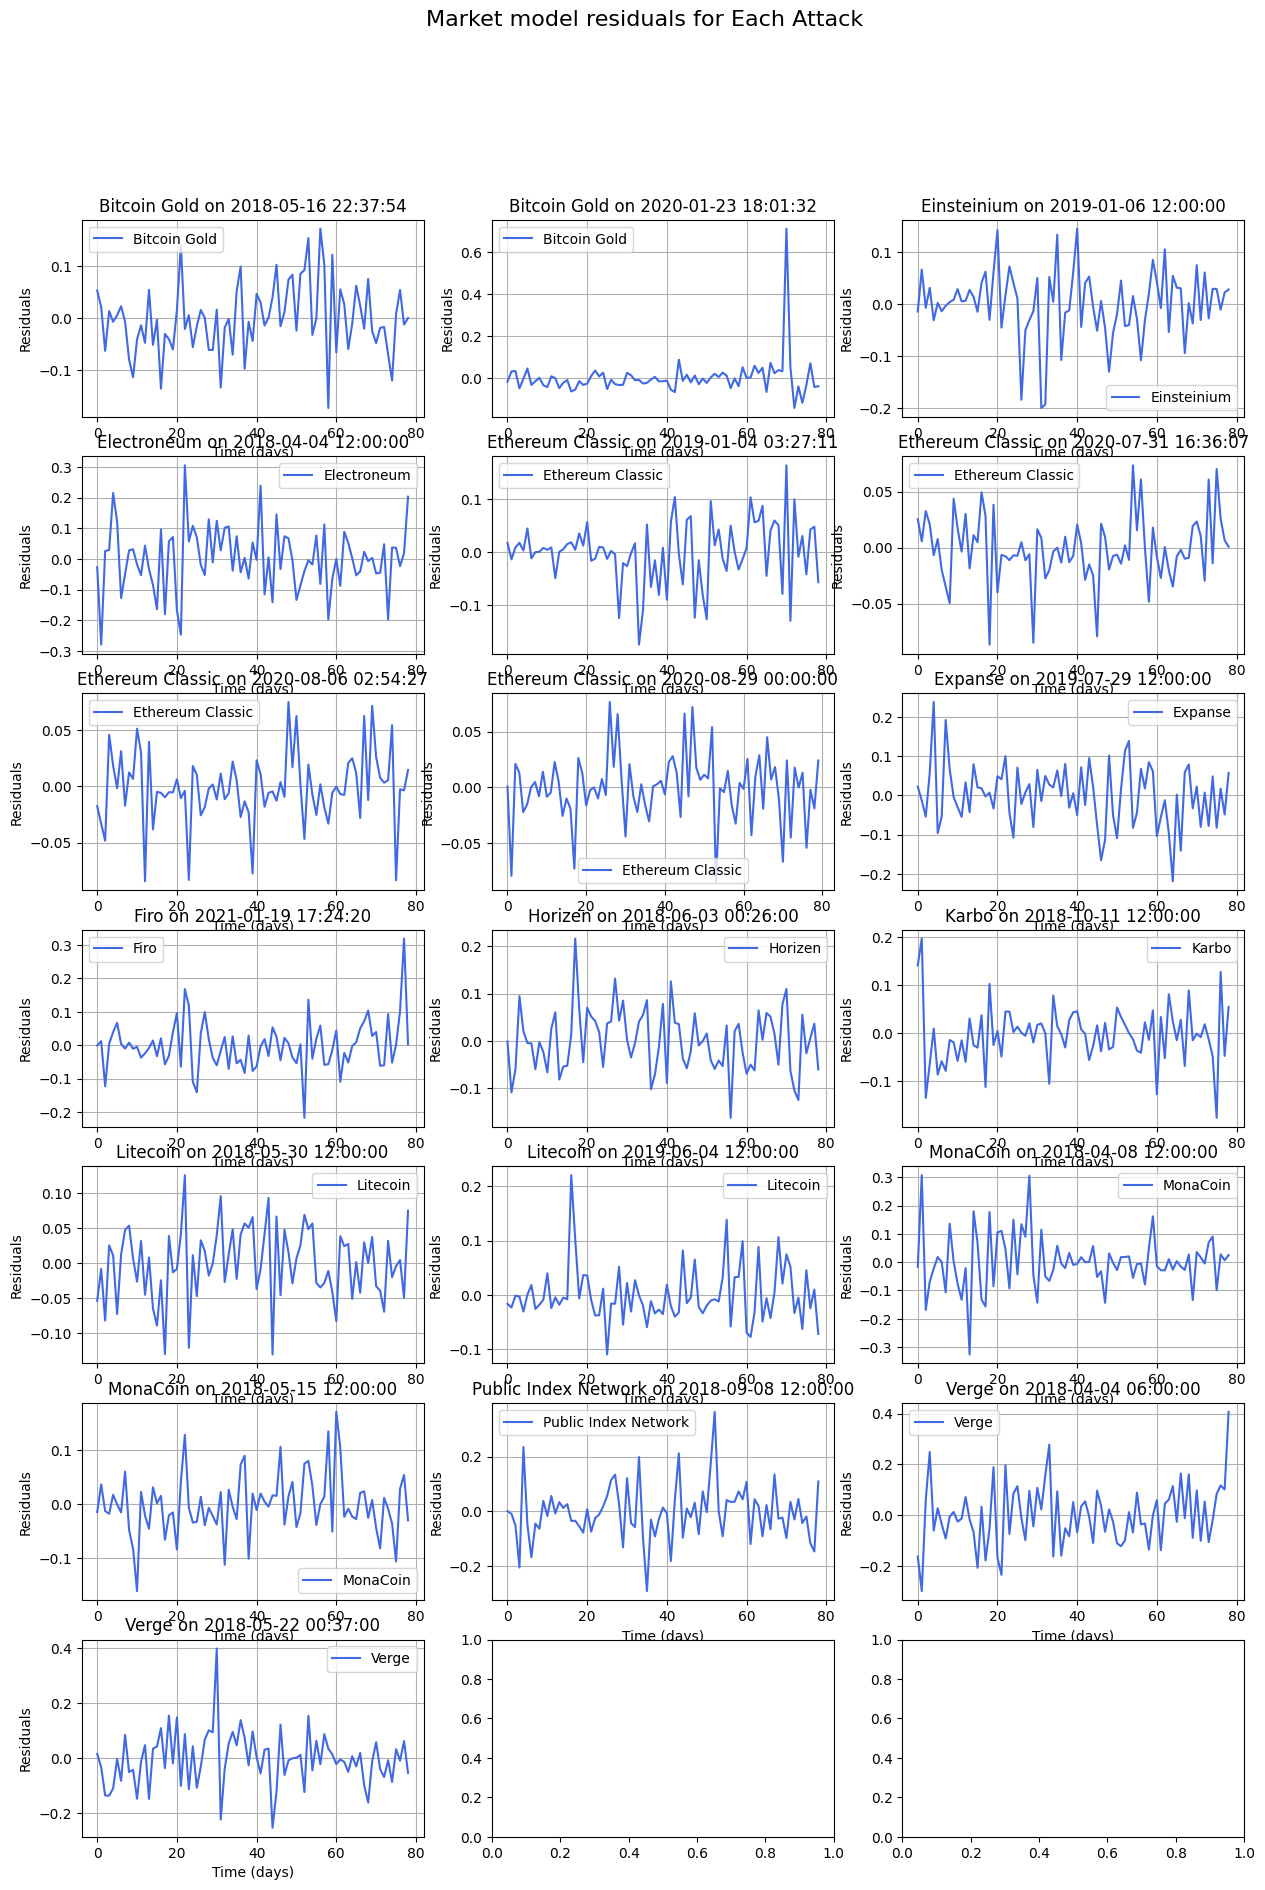

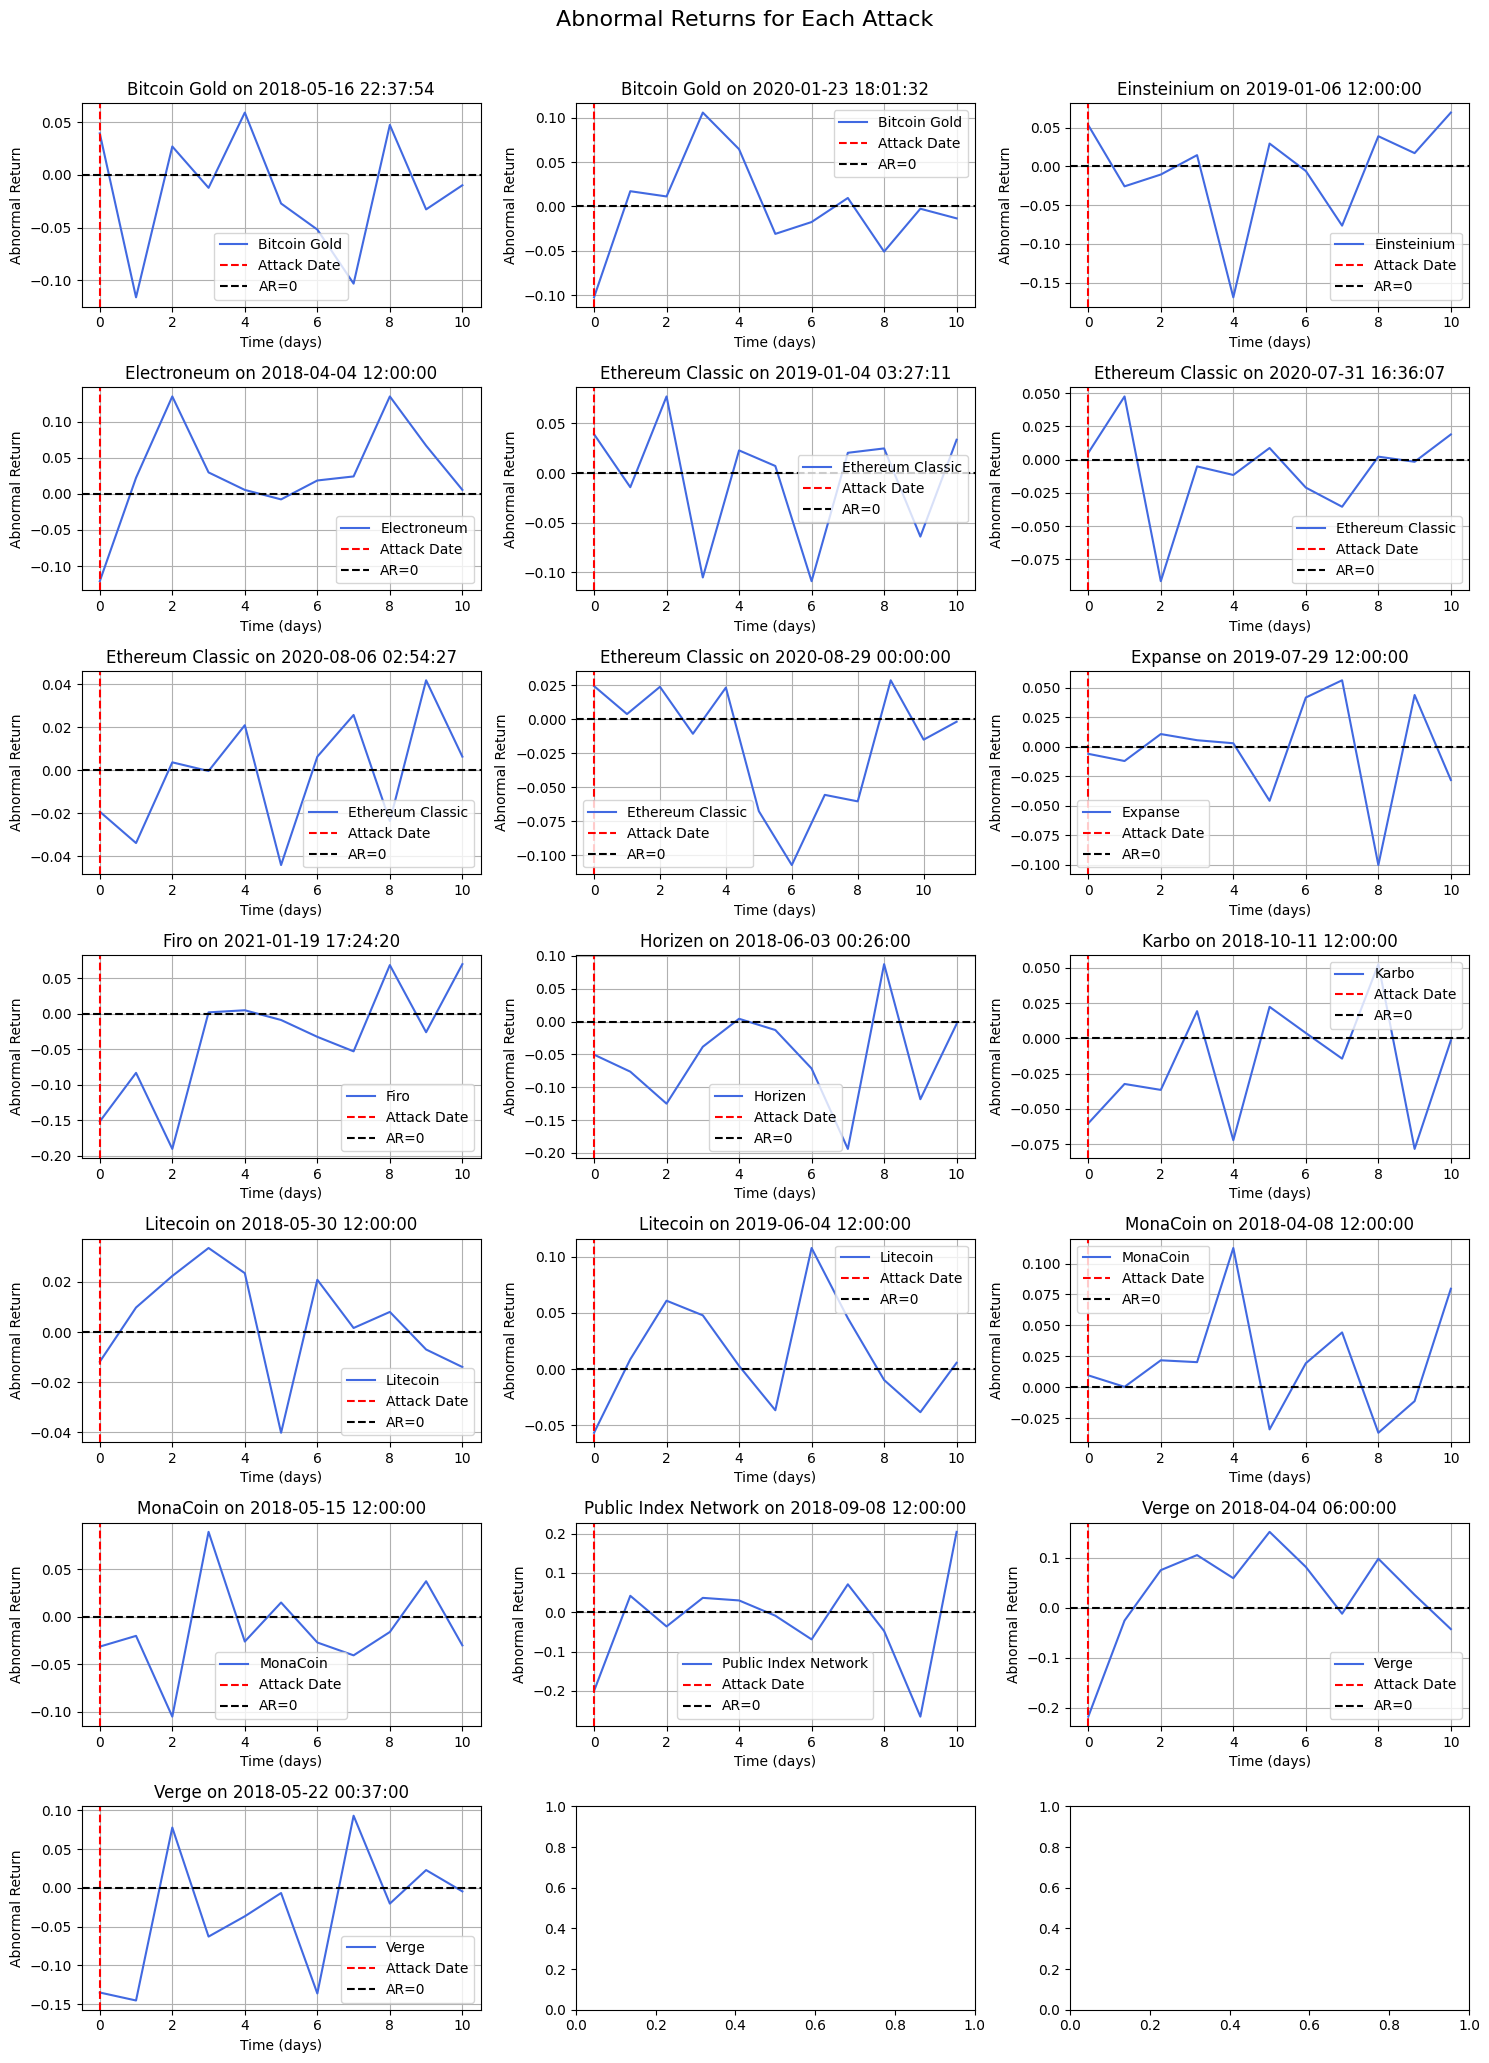

In [5]:
# Testing economic models
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)

from AR_models import MarketModel, MarketAdjustedModel, MeanAdjustedModel

# Set up the subplot grid with an appropriate size
num_attacks = sum([len(crypto.value.attack_dates) for crypto in Cryptos])
# Set up the subplot grid with 3 columns
cols = 3
rows = math.ceil(num_attacks / cols)
fig1, axs1 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig1.suptitle("Market model residuals for Each Attack", fontsize=16)
fig2, axs2 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig2.suptitle("Abnormal Returns for Each Attack", fontsize=16)

# Flatten axs array if there are multiple rows and columns
axs1 = axs1.flatten()
axs2 = axs2.flatten()

horizon = 10
estimation_window_size = 80
result_data = pd.DataFrame()
abnormal_returns = list()

i=0
for crypto in Cryptos:
  for attack_date in crypto.value.attack_dates:
    crypto_data = pd.DataFrame()
    # Sample data
    asset_returns = crypto.value.data['log_returns']
    market_returns = crypto.value.data['market_log_returns']

    # Market Model Example
    mm = MarketModel(asset_returns, market_returns, attack_date, estimation_window_size, horizon)
    mm_data = pd.DataFrame(data=mm.verify_assumptions())
    mm_data['name'] = mm.name
    mm_data['value'] = mm.calculate_CAR()
    test_data = testing_abnormal_returns(mm.abnormal_returns)
    crypto_data = pd.concat([crypto_data,mm_data,test_data])

    crypto_data['crypto_name'] = crypto.value.name
    crypto_data['attack_date'] = attack_date
    result_data = pd.concat([result_data,crypto_data])

    ax1 = axs1[i] if num_attacks > 1 else axs1
    
    # Plot abnormal returns series for the current cryptocurrency
    ax1.plot(mm.residuals.values, color='royalblue', label=f'{crypto.value.name}')
    
    # Set titles and labels
    ax1.set_title(f'{crypto.value.name} on {attack_date}')
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Residuals")
    ax1.legend()
    ax1.grid(True)

    ax2 = axs2[i] if num_attacks > 1 else axs2
    
    # Plot abnormal returns series for the current cryptocurrency
    ax2.plot(mm.abnormal_returns.values, color='royalblue', label=f'{crypto.value.name}')
    
    # Mark the attack date (assuming it's index 0 for simplicity; otherwise adjust as needed)
    ax2.axvline(x=0, color='red', linestyle='--', label='Attack Date')
    ax2.axhline(y=0, color='black', linestyle='--', label='AR=0')
    
    # Set titles and labels
    ax2.set_title(f'{crypto.value.name} on {attack_date}')
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Abnormal Return")
    ax2.legend()
    ax2.grid(True)

    i+=1

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
    
result_data.to_csv("AR_result_data")

**OBSERVATION**

- We can observe that the order of magnitude of the abnormal return is that of the residuals, as the returns are very volatile. This confirms our concerns that the rigidity of the market model may prevent the abnormal return from being significant. When looking at the residuals, we find that the abnormal returns are quite similar to what would be considered normal, which complicates the analysis.

{'stationarity': True, 'autocorrelation': np.True_, 'heteroskedasticity': np.False_}


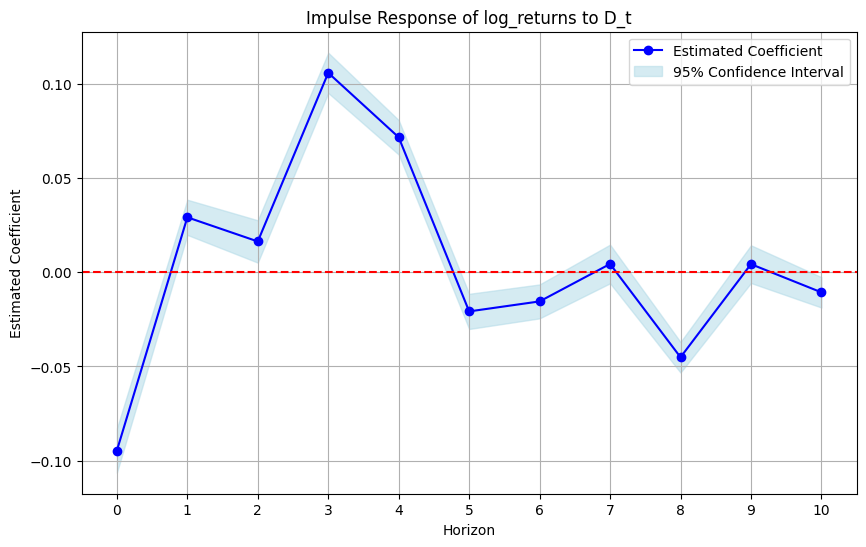

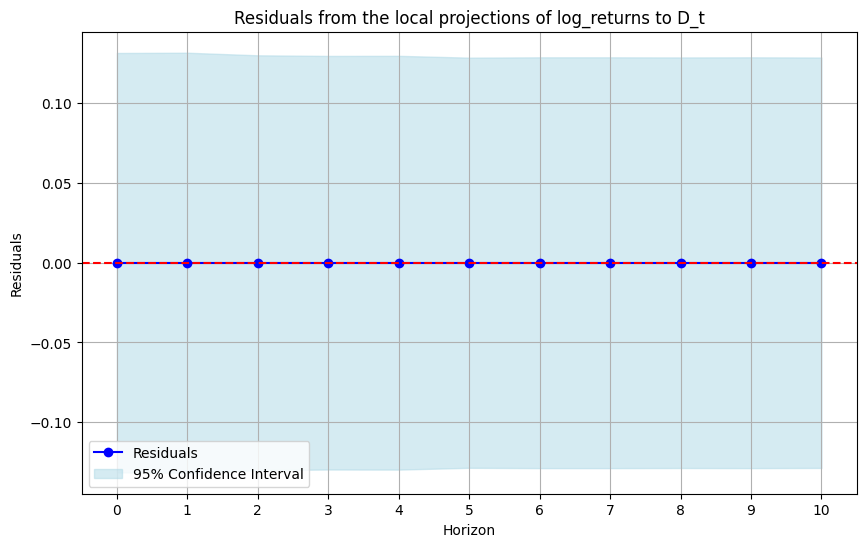

Durbin-Watson statistic: 1.998175107430542
     lb_stat  lb_pvalue
10  2.659774   0.988337


<Figure size 1000x600 with 0 Axes>

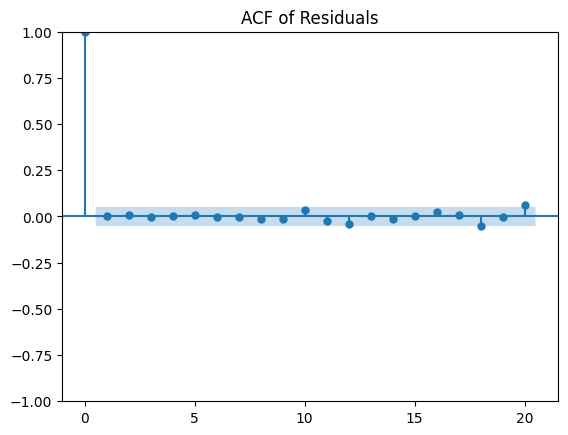

Durbin-Watson statistic: 2.0389312295197524
     lb_stat  lb_pvalue
10  4.601723   0.916149


<Figure size 1000x600 with 0 Axes>

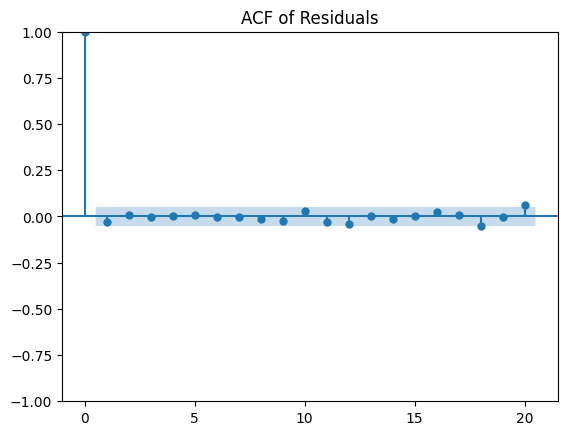

Durbin-Watson statistic: 2.044188579843435
     lb_stat  lb_pvalue
10  5.995459   0.815645


<Figure size 1000x600 with 0 Axes>

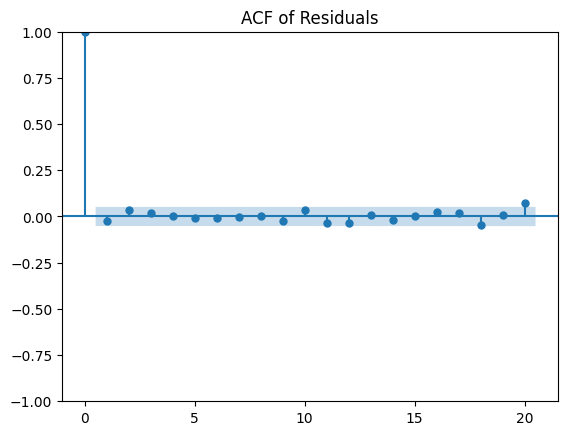

Durbin-Watson statistic: 2.049475373326463
     lb_stat  lb_pvalue
10  4.775874   0.905638


<Figure size 1000x600 with 0 Axes>

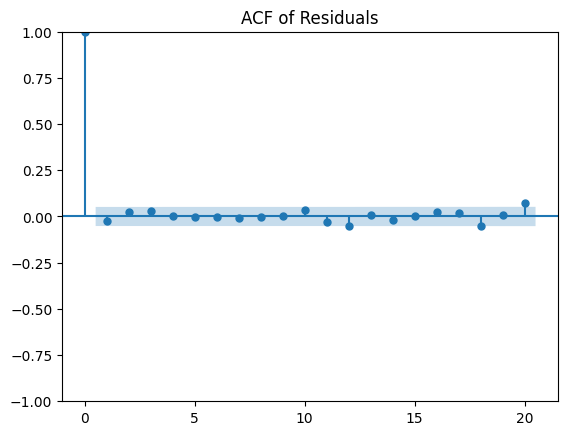

Durbin-Watson statistic: 2.0314200770153583
    lb_stat  lb_pvalue
10  3.81129   0.955459


<Figure size 1000x600 with 0 Axes>

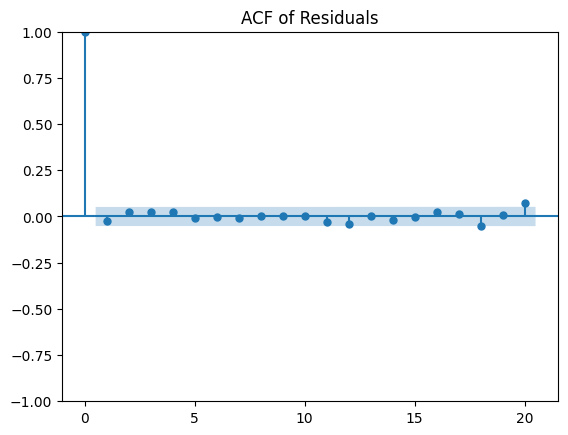

Durbin-Watson statistic: 2.0513106808098334
     lb_stat  lb_pvalue
10  5.661549   0.842852


<Figure size 1000x600 with 0 Axes>

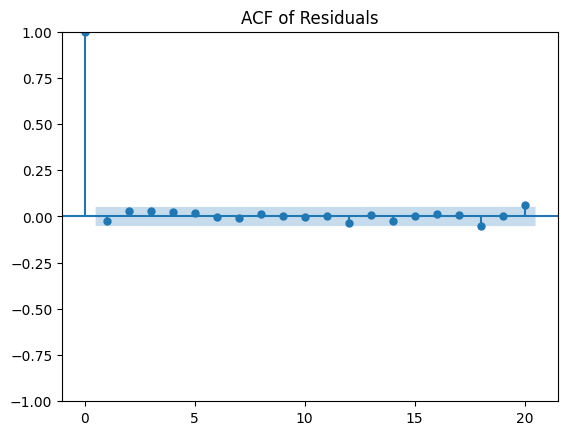

Durbin-Watson statistic: 2.0464859453869284
     lb_stat  lb_pvalue
10  10.61133   0.388589


<Figure size 1000x600 with 0 Axes>

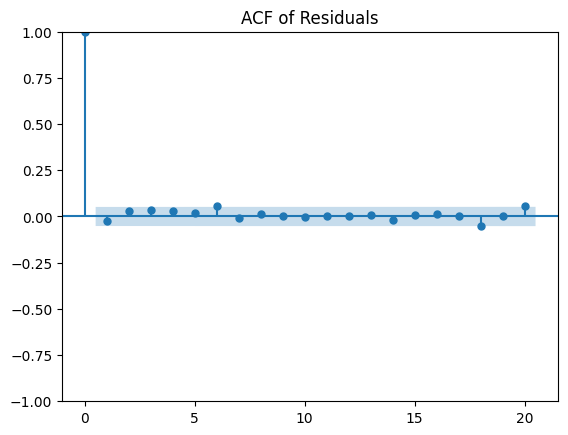

Durbin-Watson statistic: 2.0470981519306513
      lb_stat  lb_pvalue
10  10.942862   0.361987


<Figure size 1000x600 with 0 Axes>

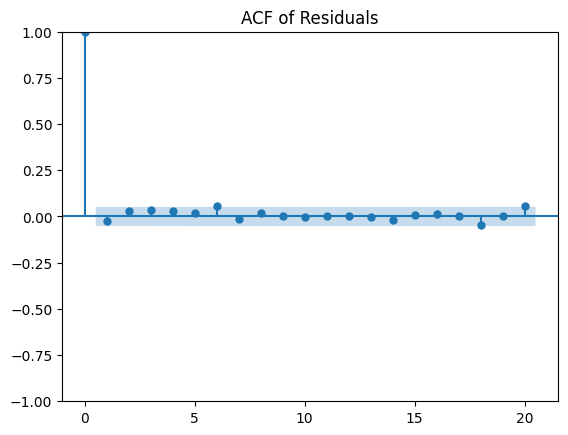

Durbin-Watson statistic: 2.049962442065871
      lb_stat  lb_pvalue
10  10.769223   0.375778


<Figure size 1000x600 with 0 Axes>

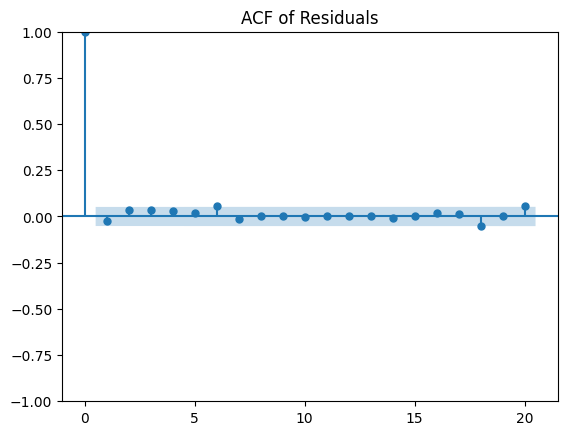

Durbin-Watson statistic: 2.0443511448607024
      lb_stat  lb_pvalue
10  10.931344   0.362892


<Figure size 1000x600 with 0 Axes>

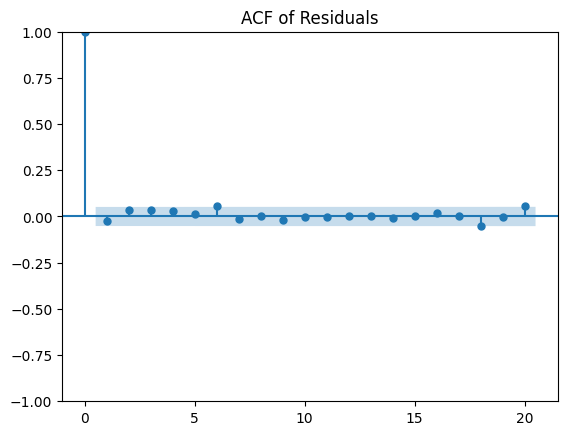

Durbin-Watson statistic: 2.051921580334331
      lb_stat  lb_pvalue
10  13.939639   0.175763


<Figure size 1000x600 with 0 Axes>

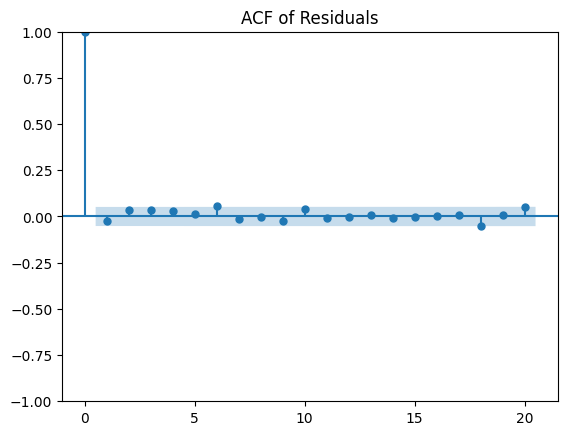

In [20]:
# Local projections
from local_projections import LocalProjectionsModel
dates = Cryptos.BTG.value.data.index
returns = Cryptos.BTG.value.data.log_returns
market_returns = Cryptos.BTG.value.data.market_log_returns

data = pd.DataFrame({
    'date': dates,
    'log_returns': returns,
    'market_log_returns': market_returns
})

event_dates = [Cryptos.BTG.value.attack_dates[1]]

# Initialize the Local Projections Model
dependent_var = 'log_returns'
shock_var = 'D_t'
control_vars = ['market_log_returns']
model = LocalProjectionsModel(data, dependent_var, shock_var, control_vars)

# Construct local projection data
horizon = 10
num_lags = 6
lp_data = model.construct_local_projection_data(event_dates, num_lags)
ifs = model.run_local_projections(event_dates, horizon, num_lags=num_lags,)

# Validate assumptions
assumption_checks = model.validate_assumptions()
print(assumption_checks)
# Plot the results
model.plot_projections()
residuals = model.residuals.dropna()
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
for res in range(horizon+1):
    # Calculate the Durbin-Watson statistic
    dw_stat = durbin_watson(residuals[res])
    print(f'Durbin-Watson statistic: {dw_stat}')
    # Perform the Ljung-Box test
    lb_test = acorr_ljungbox(residuals[res], lags=[10], return_df=True)
    print(lb_test)
    # Assuming `residuals` is a Series or array of your model's residuals
    plt.figure(figsize=(10, 6))
    plot_acf(residuals[res], lags=20)
    plt.title('ACF of Residuals')
    plt.show()

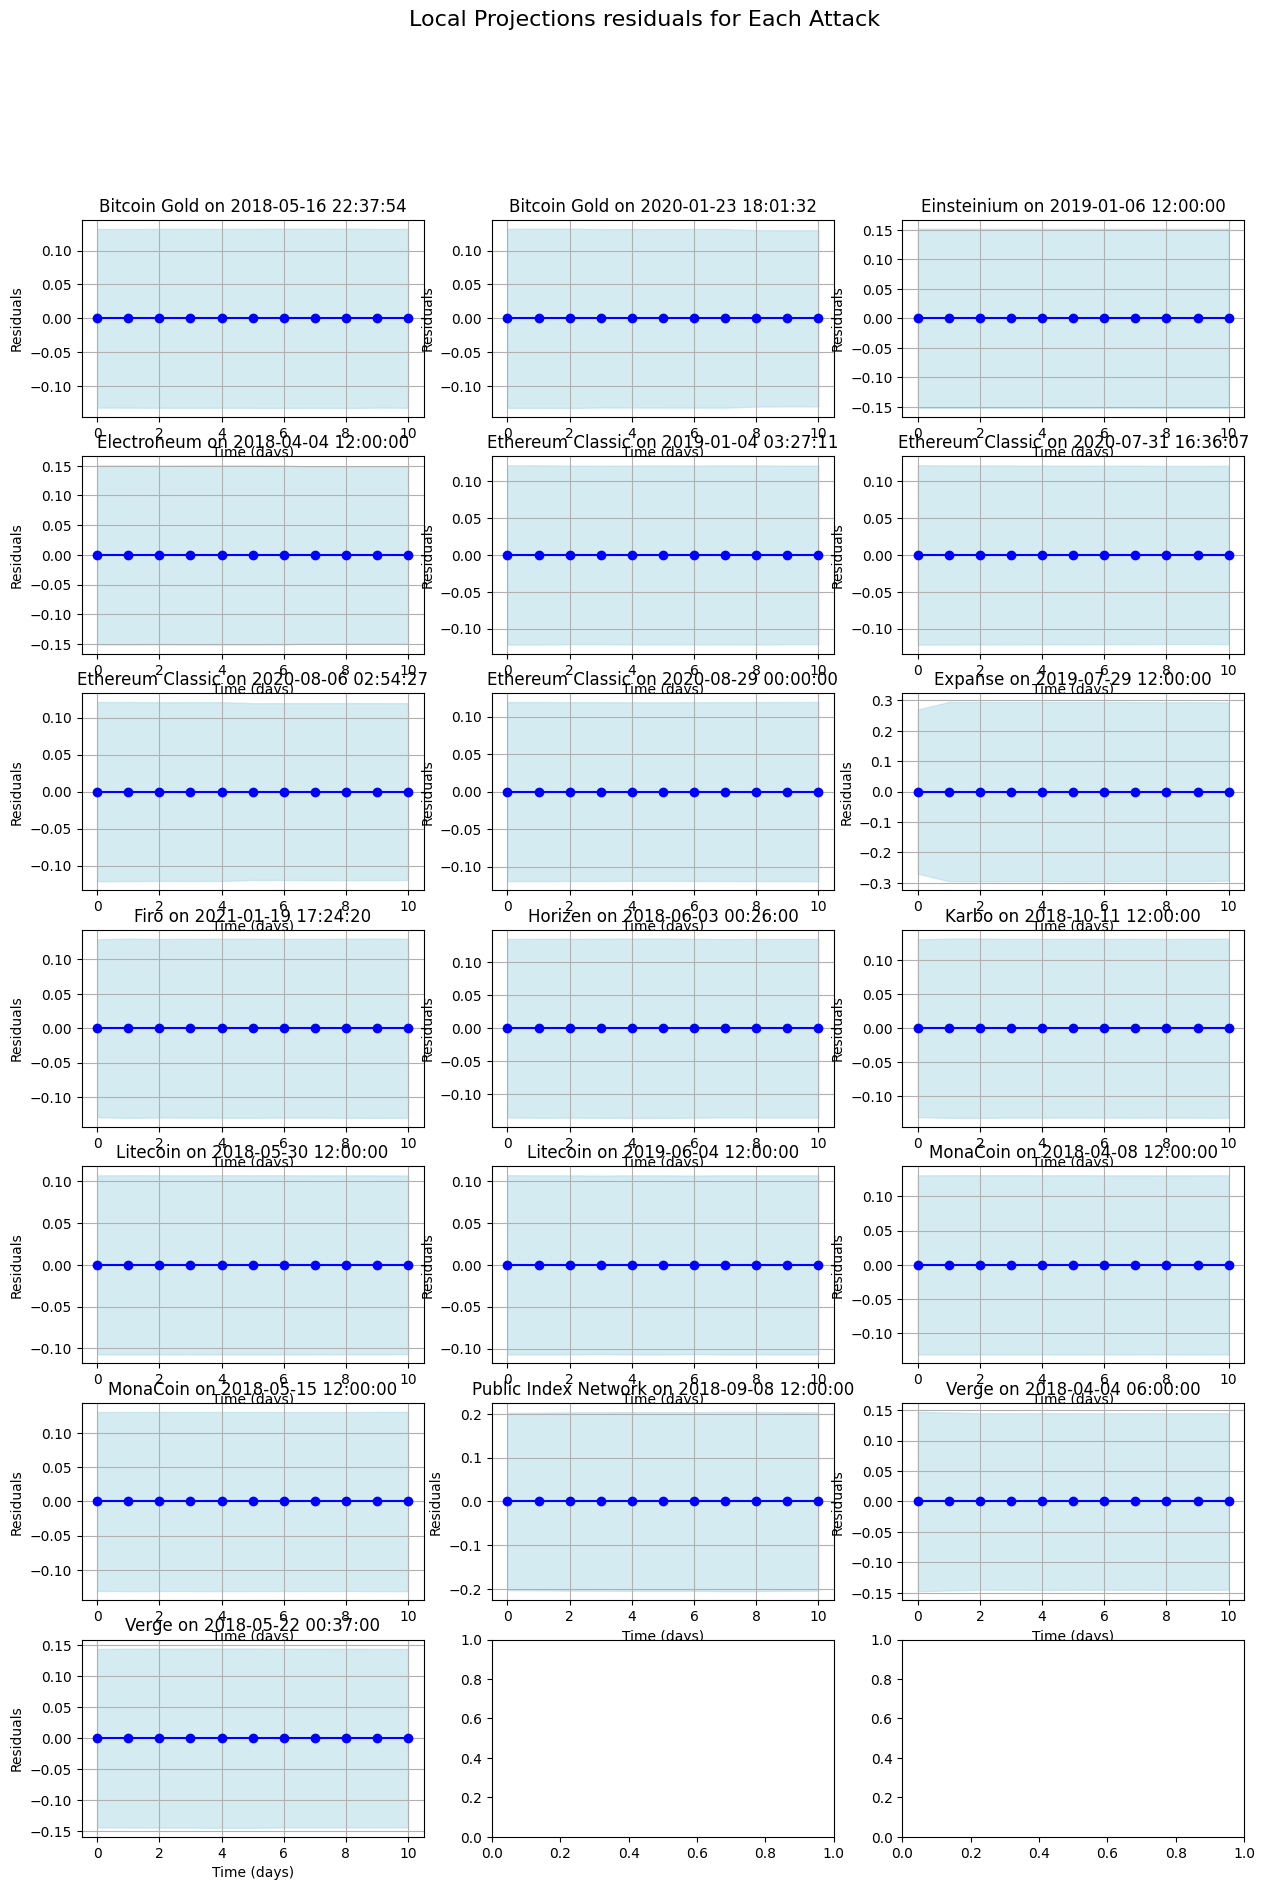

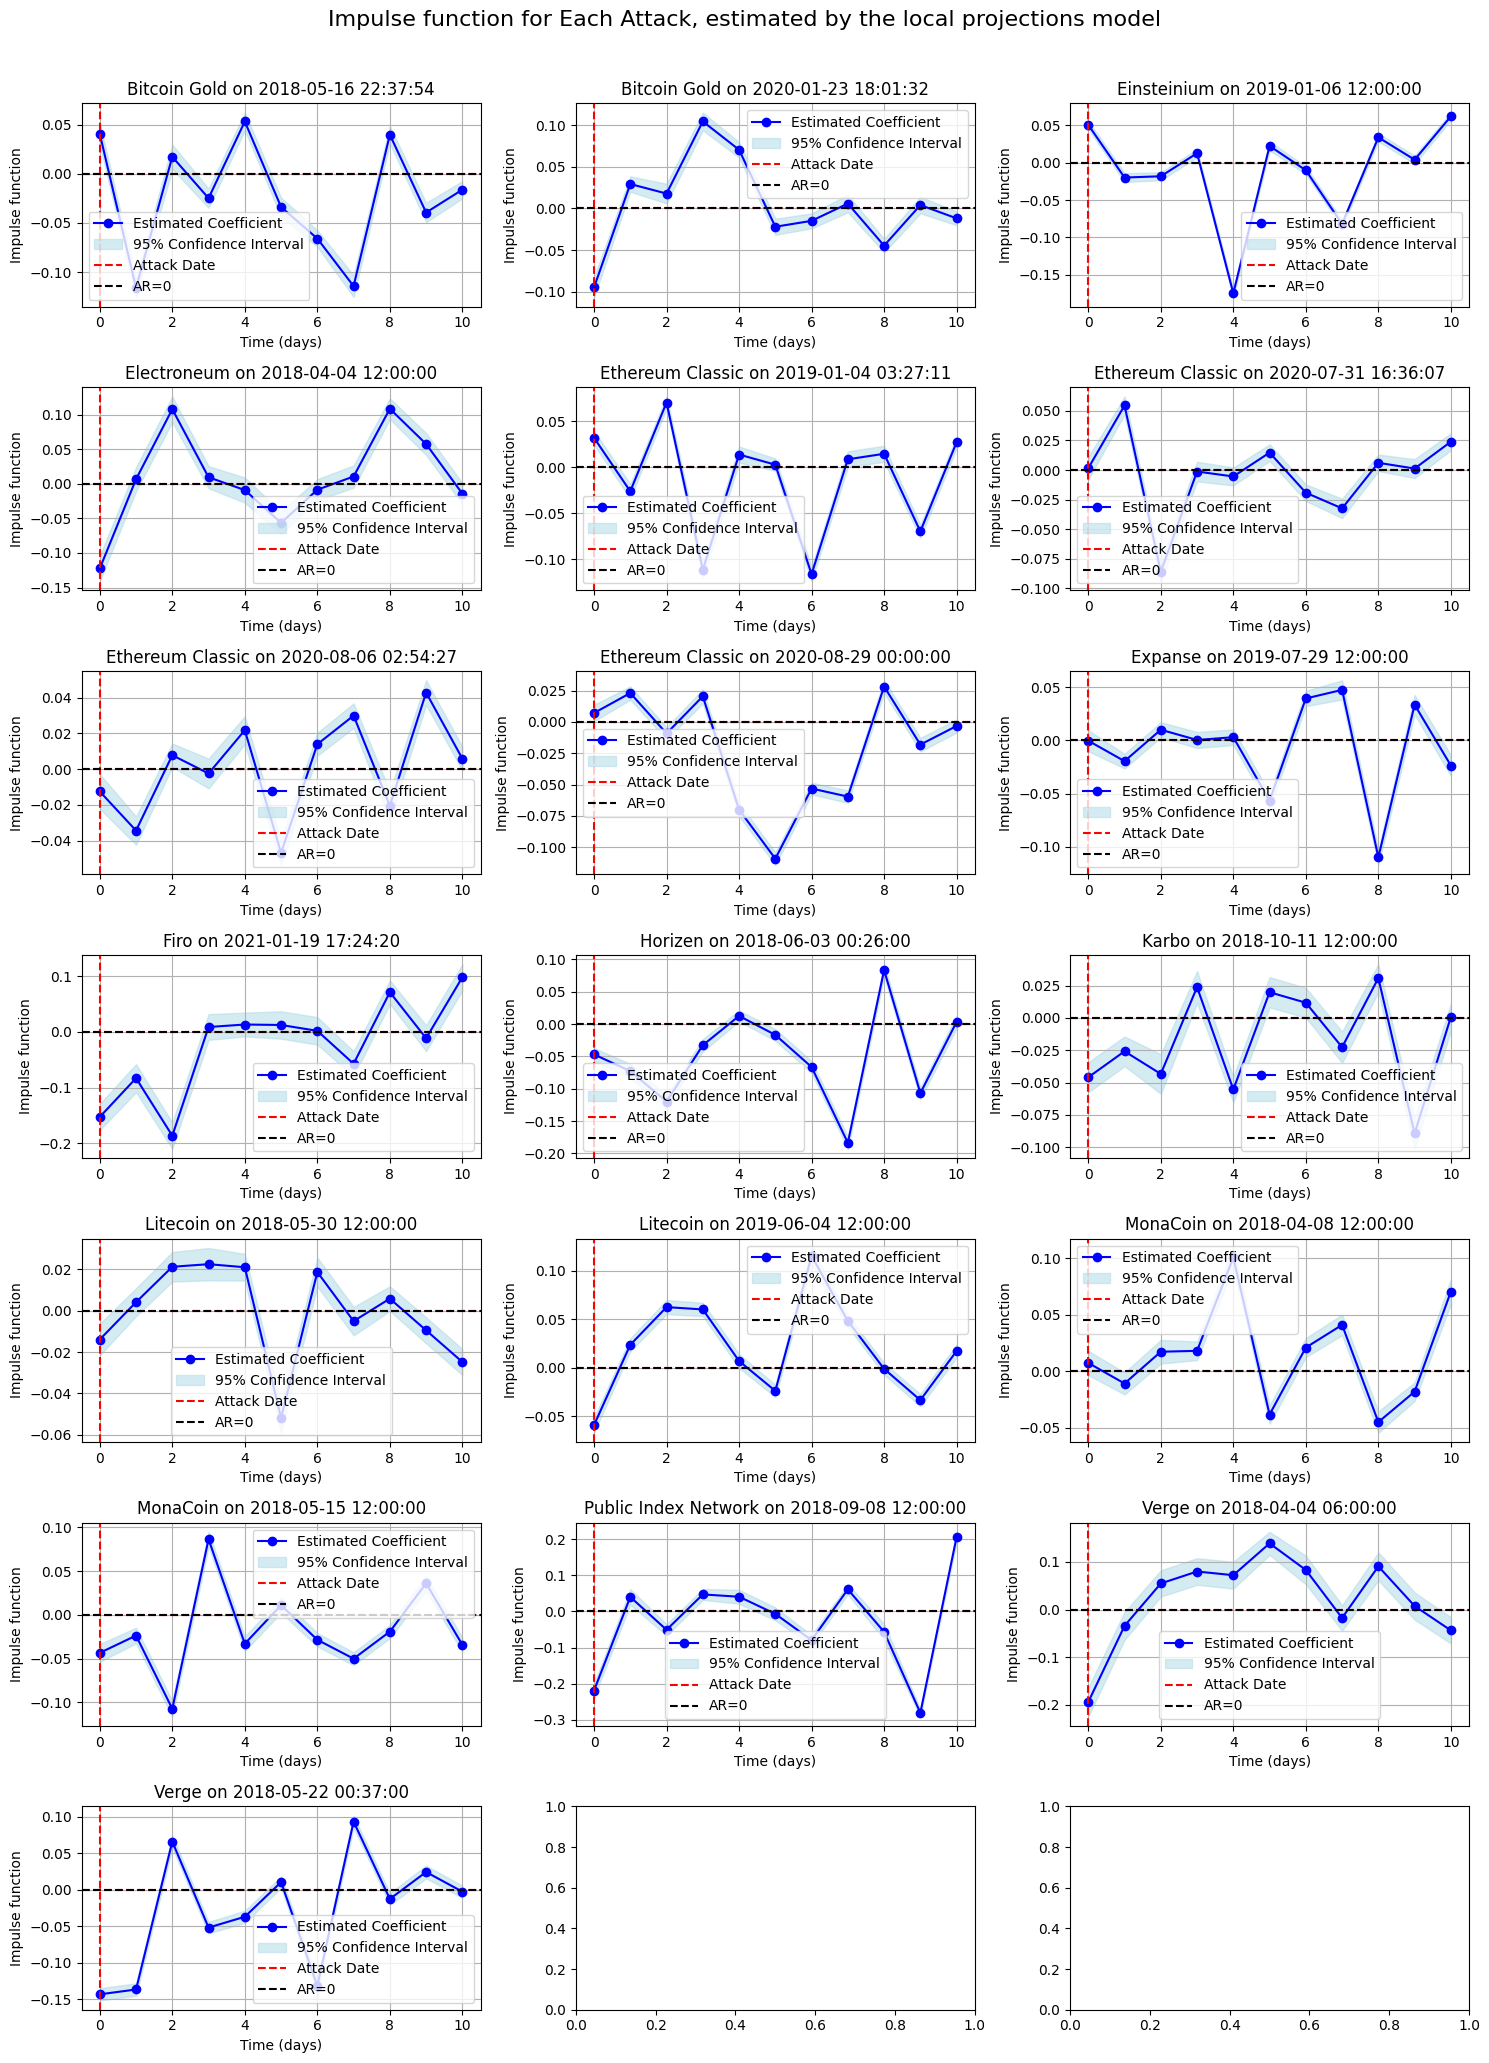

In [7]:
# Testing economic models
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)

from AR_models import MarketModel, MarketAdjustedModel, MeanAdjustedModel
# Fix seed for reproducibility
np.random.seed(42)
# Set up the subplot grid with an appropriate size
num_attacks = sum([len(crypto.value.attack_dates) for crypto in Cryptos])
# Set up the subplot grid with 3 columns
cols = 3
rows = math.ceil(num_attacks / cols)
fig1, axs1 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig1.suptitle("Local Projections residuals for Each Attack", fontsize=16)
fig2, axs2 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig2.suptitle("Impulse function for Each Attack, estimated by the local projections model", fontsize=16)

# Flatten axs array if there are multiple rows and columns
axs1 = axs1.flatten()
axs2 = axs2.flatten()

horizon = 10
num_lags = 6
estimation_window_size = 80
result_data = pd.DataFrame()
assumptions_data = pd.DataFrame(columns=['stationarity','autocorrelation','heteroskedasticity','crypto_name','attack_date'])
horizons = list(range(horizon+1))

i=0
for crypto in Cryptos:
  for attack_date in crypto.value.attack_dates:
    crypto_data = pd.DataFrame()

    data = crypto.value.data
    event_dates = [attack_date]

    # Initialize the Local Projections Model
    dependent_var = 'log_returns'
    shock_var = 'D_t'
    market_var = 'market_log_returns'
    model = LocalProjectionsModel(data, dependent_var, shock_var, market_var=market_var)

    lp_data = model.construct_local_projection_data(event_dates, num_lags)

    # Run local projections
    projections = model.run_local_projections(event_dates, horizon, num_lags=num_lags,)
    mean_impact =  projections['Mean_IRF']

    # Validate assumptions
    # mm_data = pd.DataFrame(data=model.validate_assumptions())
    crypto_data = pd.DataFrame(model.validate_assumptions(),index=[i])
    crypto_data['crypto_name'] = crypto.value.name
    crypto_data['attack_date'] = attack_date
    crypto_data['mean_IRF'] = crypto.value.name
    crypto_data['min_IRF'] = mean_impact.min()
    crypto_data['max_IRF'] = mean_impact.max()
    crypto_data['std_IRF'] = mean_impact.std()
    assumptions_data = pd.concat([assumptions_data,crypto_data])


    ax1 = axs1[i] if num_attacks > 1 else axs1
    # Convert necessary columns to numeric, setting errors='coerce' to handle any non-numeric values
    projections["Horizon"] = pd.to_numeric(projections["Horizon"], errors='coerce')
    projections["Mean_resid"] = pd.to_numeric(projections["Mean_resid"], errors='coerce')
    projections["LB_resid"] = pd.to_numeric(projections["LB_resid"], errors='coerce')
    projections["UB_resid"] = pd.to_numeric(projections["UB_resid"], errors='coerce')

    # Drop rows where any of the required columns contain NaN values
    projections.dropna(subset=["Horizon", "Mean_resid", "LB_resid", "UB_resid"], inplace=True)

    # Proceed with the plot after cleaning the data
    ax1.plot(projections['Horizon'], projections['Mean_resid'], marker='o', linestyle='-', color='b', label='Estimated Coefficient')
    ax1.fill_between(projections['Horizon'], projections['LB_resid'], projections['UB_resid'], color='lightblue', alpha=0.5, label='95% Confidence Interval')

    # Set titles and labels
    ax1.set_title(f'{crypto.value.name} on {attack_date}')
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Residuals")
    # ax1.legend()
    ax1.grid(True)

    ax2 = axs2[i] if num_attacks > 1 else axs2
    ax2.plot(projections['Horizon'], mean_impact, marker='o', linestyle='-', color='b', label='Estimated Coefficient')
    ax2.fill_between(projections['Horizon'], projections['LB_IRF'], projections['UB_IRF'], color='lightblue', alpha=0.5, label='95% Confidence Interval')
    ax2.axhline(0, color='r', linestyle='--')
    # Mark the attack date (assuming it's index 0 for simplicity; otherwise adjust as needed)
    ax2.axvline(x=0, color='red', linestyle='--', label='Attack Date')
    ax2.axhline(y=0, color='black', linestyle='--', label='AR=0') 
    # Set titles and labels
    ax2.set_title(f'{crypto.value.name} on {attack_date}')
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Impulse function")
    ax2.legend()
    ax2.grid(True)

    i+=1


# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
    
result_data.to_csv("AR_result_data")

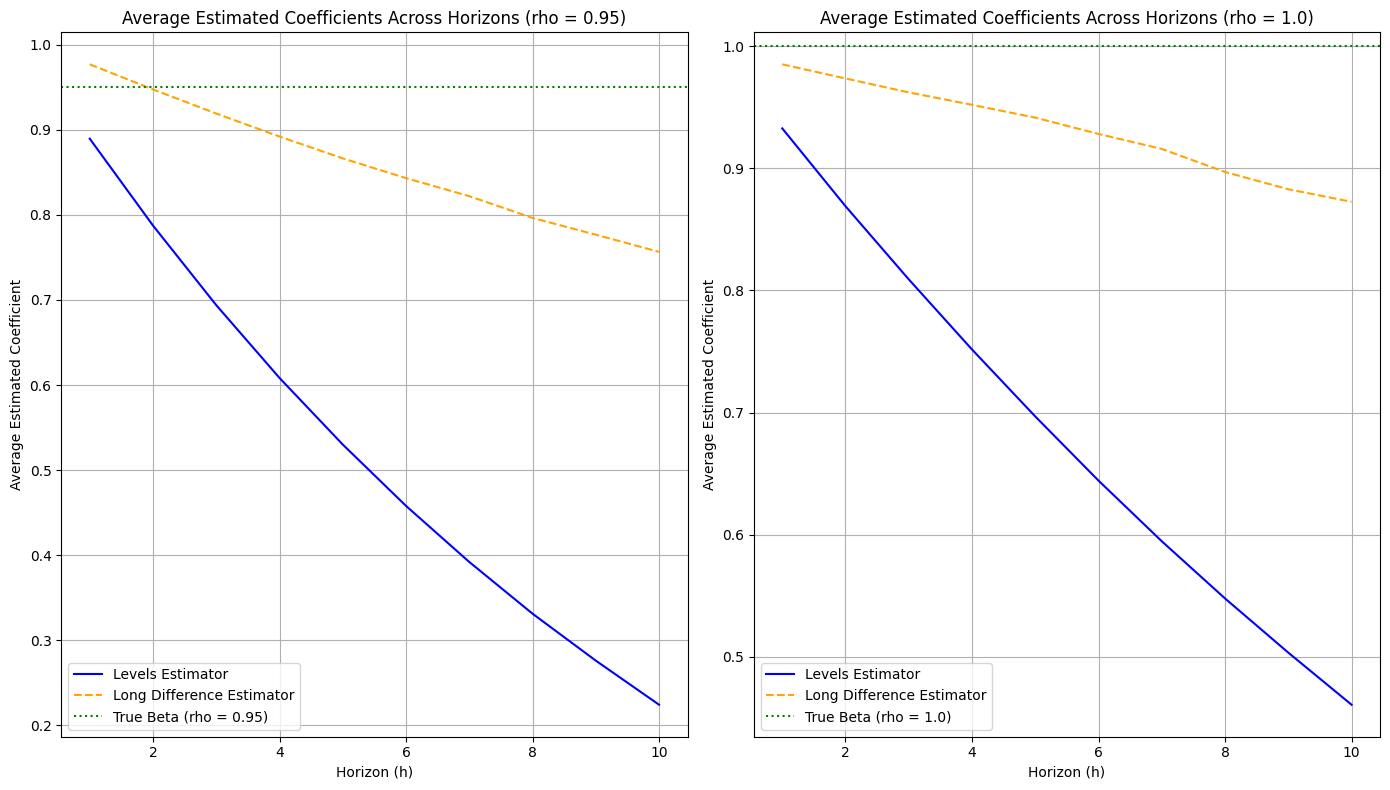

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set parameters
T = 80      # Sample size for each simulation
N_sims = 1000  # Number of Monte Carlo simulations
rho_values = [0.95, 1.0]
horizons = 10

# Fix seed for reproducibility
np.random.seed(42)

# Initialize dictionary to store results
results = {rho: {'levels': np.zeros((N_sims, horizons)),
                 'long_diff': np.zeros((N_sims, horizons))} for rho in rho_values}

# Monte Carlo Simulation
for rho in rho_values:
    for sim in range(N_sims):
        # Generate time series for each simulation
        y = np.zeros(T)
        s = np.random.normal(0, 1, T)
        epsilon = np.random.normal(0, 1, T)
        
        # Generate the series according to the DGP
        for t in range(1, T):
            y[t] = s[t] + rho * y[t-1] + epsilon[t]
        
        # Estimate coefficients for each horizon
        for h in range(1, horizons + 1):
            # Prepare data for the OLS regression at horizon h
            y_t = y[1:T-h]  # Independent variable: y_t
            y_th = y[h+1:T]  # Dependent variable for levels estimator: y_{t+h}
            diff_y_h = y_th - y[:T-h-1]  # Dependent variable for long difference estimator
            diff_y_t = y_t - y[:T-h-1]  # Dependent variable for long difference estimator
            
            # Add constant to y_t for OLS
            y_t_const = sm.add_constant(y_t)
            diff_y_t_const = sm.add_constant(diff_y_t)
            
            # Levels estimator OLS: Regress y_{t+h} on y_t
            model_levels = sm.OLS(y_th, y_t_const).fit()
            results[rho]['levels'][sim, h-1] = model_levels.params[1]  # Store coefficient of y_t
            
            # Long difference estimator OLS: Regress (y_{t+h} - y_t) on y_t
            model_long_diff = sm.OLS(diff_y_h, diff_y_t_const).fit()
            results[rho]['long_diff'][sim, h-1] = model_long_diff.params[1]  # Store coefficient of y_t

# Plotting the average coefficients across simulations for each rho in subplots
plt.figure(figsize=(14, 8))

for i, rho in enumerate(rho_values):
    avg_levels = np.mean(results[rho]['levels'], axis=0)
    avg_long_diff = np.mean(results[rho]['long_diff'], axis=0)
    
    plt.subplot(1, 2, i + 1)
    plt.plot(range(1, horizons + 1), avg_levels, label="Levels Estimator", color="blue")
    plt.plot(range(1, horizons + 1), avg_long_diff, label="Long Difference Estimator", color="orange", linestyle="--")
    
    # Horizontal line for the true beta
    plt.axhline(y=rho, color='green', linestyle=':', label=f'True Beta (rho = {rho})')
    
    plt.xlabel("Horizon (h)")
    plt.ylabel("Average Estimated Coefficient")
    plt.title(f"Average Estimated Coefficients Across Horizons (rho = {rho})")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


**OBSERVATION**
- LP gives the same clustering as CAR method
- LP shows higher impact of the attack that CAR method.